# FIN30200: Econometrics of Financial Markets
Group Project - Modeling Exchange Rate Volatility: Application of the GARCH and EGARCH Models 

Ciaran Maxwell: 19327416

Conor Gallagher: 19415714

Liam Holland: 19457642

Mark Mullins: 19341043

Odhran Murphy: 19469442

## Import Libraries

In [1]:
# Import the standard data analysis libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# Import libraries for web scraping
import requests
import numpy as np
from tqdm import tqdm
import pickle, os
import bs4 as bs
from time import sleep

# Time Series Analysis Library: AR,VAR,ARMA; ACF&PACF
import statsmodels.tsa as tsa

# Regression and Regression Test Libraries
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

# Import acf & pacf plotting functions 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Plotting library
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
import seaborn as sns

# Calling Python magic command
%matplotlib inline
# Adjust the figure size
matplotlib.rcParams['figure.figsize']=[10,6]

# Module to use
import os

# Import ARCH
from arch import arch_model

# Import ADF and PP unit root tests
from arch.unitroot import ADF
from arch.unitroot import PhillipsPerron as PP

# Import Shapiro-Wilk test
from scipy.stats import shapiro as sw

# Ljung-Box test function
from statsmodels.stats.diagnostic import acorr_ljungbox

# Import datetime library
import datetime as dt 

# Import markdown display module
from IPython.display import Markdown

# Forecast accuracy measures: 'sklearn' library: sklearn.metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Current Directory

In [2]:
print(os.getcwd())

C:\Users\Odhran Murphy\Documents\College\4. Fourth Year\Semester 1\FIN30200 - Econometrics of Financial Markets\Group Project


## Set GitHub Repository

In [3]:
base_url = 'https://raw.githubusercontent.com/odhran-murphy/EFM_Group_Project/main' 

## Common Plotting Functions

#### `plot_series`

In [4]:
def plot_series(series, title, ylabel):
    """Plot the series against the time index of dataframe."""
    
    plt.plot(series)    
    plt.xlabel('Date')
    plt.ylabel(ylabel) 
    plt.title(title) 
    plt.show()

#### `plot_acf_pacf`

In [5]:
def plot_acf_pacf(series, title):
    """Display both acf and pacf using a shared x-axis."""  
    
    fig, axes = plt.subplots(nrows=2, figsize=(10, 6))

    plot_acf(series, lags=40,ax=axes[0]) 
    plot_pacf(series, lags=40,ax=axes[1], method='ywm')
    plt.suptitle(title)
    plt.show()

#### `plot_series_v_normal`

In [6]:
def plot_series_v_normal(series, series_label, title):
    """Plot series histogram v normal distribution"""  
    
    # Applying the seaborn distplot function to get histogram & density curve of series 
    sns.histplot(series, kde=True, color='darkblue', stat='density', label = series_label)

    # Normal distribution with the same mean & variance
    np.random.seed(0) # Fixed seed to use

    # Random variable with normal distribution
    normal_sample = np.random.normal(np.mean(series), np.std(series), 249)

    # Applying the Gaussian kernel density estimate to get the density curve
    sns.kdeplot(normal_sample, color='red', shade=True, label = "Normal")
    
    plt.title(title)
    plt.legend()
    plt.show()

## Data Download and Data Processing
This paper uses both GARCH (1,1) and EGARCH (1,1) to model the volatility of TZS/USD exchange rate for the January 4, 2009 - July 27, 2015 period.

A number of sources were accessed to obtained the data needed to reproduce the work described in REF.  

Initially, obtaining the data directly from the Bank of Tanzania was attempted, but the web interface only reported historical exchange rates on a daily basis. So other options were explored. Some services such as [Exchangr](app.getexchangr.com), had limited historical data while others on the free tier, such as, [FXMarketAPI](https://fxmarketapi.com), do not support TZS. 

[Investing.com](https://www.investing.com/currencies/usd-tzs-historical-data) does support TZS over the required time interval. However, the Investing.com data contained more data points (1711 vs 1593) and is both more noisy and contains a number of outlier observations. So while the global structure of Investing.com data is comparable to the data used in the paper, it is not suitable for any analysis focusing on the differences between continuous data points.

Obtaining the data directly from the Bank of Tanzania required a web scraper. Looping over each day in the interval 2009-01-04 to 2015-07-27. This represents 2396 days, or on skipping weekends, 1711 days. Web scraping over each of the 1711 weekdays resulted in 1613 data points (most probably due to bank holidays, etc.). Due to speed of remote server, run time is about 1 hour. 

The Bank of Tanzania data set contained _Buying_, _Selling_, and _Mean_ variables. On comparison with the paper, it appears that _Selling_ or _Mean_ was used.

Using a plot digitizer (https://automeris.io/WebPlotDigitizer/), we can scan figure 1 and obtain data. We then compare this to the data set obtained from investing.com and directly from the 

#### www.investing.com

 * https://www.investing.com/currencies/usd-tzs-historical-data -> USD_TZS_Historical_Data.csv

In [7]:
filename = 'USD_TZS_Historical_Data.csv'
df_1 = pd.read_csv(f'{base_url}/{filename}') # TZS to 1 USD rate

df_1.Date = pd.to_datetime(df_1['Date'], format='%m/%d/%Y')
df_1.Price = df_1.Price.apply(lambda x: float(x.split()[0].replace(',', '')))

start_date = dt.datetime(2009,1,4)
end_date = dt.datetime(2015,7,27)
print("Number of days in interval of interest:", end_date-start_date)
paper_interval = (df_1.Date>=start_date) & (df_1.Date<=end_date)

df_1 = df_1[paper_interval]

df_1 = df_1[['Date', 'Price']]
df_1.set_index('Date', inplace=True) 
df_1.columns.values[0] = 'TZS_USD'
df_1 = df_1.iloc[::-1]

print(df_1.shape)
df_1.head()

Number of days in interval of interest: 2395 days, 0:00:00
(1711, 1)


,TZS_USD
Date,
2009-01-05,1325.0
2009-01-06,1340.0
2009-01-07,1339.0
2009-01-08,1343.0
2009-01-09,1357.0


__Log TZS/USD exchange rate Transformation__
$$P_{t} = \log_{10}({E_{t}})$$

$$r_{t} = \log_{10}(\frac{E_{t}}{E_{t-1}})=\log_{10}(E_{t})-\log_{10}(E_{t-1})$$

where

$P_{t}$ is the log TZS/USD exchange rate at time t

$r_{t}$ is the log TZS/USD exchange rate relative at time t

$E_{t}$ is the TZS/USD exchange rate at time t

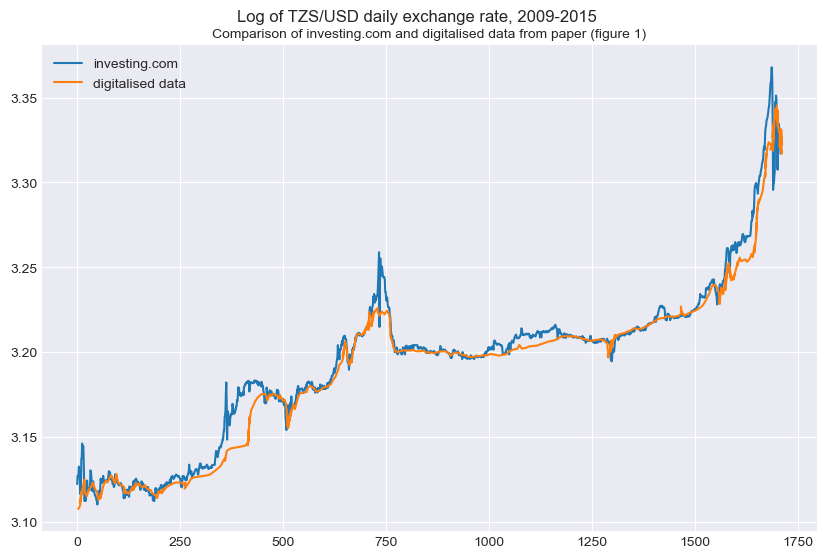

In [8]:
plt.plot(np.log10(df_1.TZS_USD.values), label="investing.com")

# digitalised data from paper fig 1
filename = 'scanned_fig_1_data.csv'
dfp = pd.read_csv(f'{base_url}/{filename}', names=['x','y'])

# dfp = pd.read_csv('scanned_fig_1_data.csv', names=['x','y'])
plt.plot(dfp.x * df_1.TZS_USD.shape / dfp.x.max(), dfp.y, label='digitalised data')

plt.legend()
plt.title('Comparison of investing.com and digitalised data from paper (figure 1)', fontsize=10)
plt.suptitle('Log of TZS/USD daily exchange rate, 2009-2015')
plt.subplots_adjust(top=0.92) #Adjusting title position
plt.show()

#### https://www.bot.go.tz/

 * https://www.bot.go.tz/ExchangeRate/previous_rates -> bank_of_tanzania_USD.csv

In [9]:
URL = "https://www.bot.go.tz/ExchangeRate/previous_rates?__RequestVerificationToken=nPOnxVhWt80SQ-DZ346Pm1IAkEGvpI9SkfSc8ELmPiCRKBSu9THfDsnBg5IHVtaVaBMem5M9ftQGLiITCkbtiN9BfwxPGnss8tRgedc3rA81&exchangeDate={month:02d}%2F{day:02d}%2F{year}"

# test pattern
URL.format(month=1, day=11, year=2009)

'https://www.bot.go.tz/ExchangeRate/previous_rates?__RequestVerificationToken=nPOnxVhWt80SQ-DZ346Pm1IAkEGvpI9SkfSc8ELmPiCRKBSu9THfDsnBg5IHVtaVaBMem5M9ftQGLiITCkbtiN9BfwxPGnss8tRgedc3rA81&exchangeDate=01%2F11%2F2009'

In [10]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + dt.timedelta(n)

start_date = dt.datetime(2009,1,4)
end_date = dt.datetime(2015,7,27) + dt.timedelta(days=1)
end_date = start_date + dt.timedelta(days=10)

print("Number of days in interval of interest:", end_date-start_date)

USE_PRE_DOWNLOADED = True

if USE_PRE_DOWNLOADED:
    print("Using pre-downloaded data ...")
    if os.path.isfile("dfs.bin"):
        with open('dfs.bin','rb') as f:
            dfs = pickle.load(f)
    else:
        print("Set USE_PRE_DOWNLOADED to scrape website.")

else:
    # perform web scrapping - takes about an hour
    print("Downloading data ...")

    weekday_count = 0
    dfs = []
    for date in tqdm(daterange(start_date, end_date), total=(end_date-start_date).days):
        url = URL.format(month=date.month, day=date.day, year=date.year)
        #print(date.strftime("%Y-%m-%d"), "WEEKEND" if date.weekday()>4 else date.strftime("%A"))

        if date.weekday()>4: continue
        weekday_count += 1

        r = requests.get(url)

        soup = bs.BeautifulSoup(r.content, 'html5lib')
        table = soup.find("table",{"id":"table1"})
        if table is None: continue

        headers = [tr.text.split('\n') for tr in table.find_all('thead')][0]
        columns = [h.strip() for h in headers if h.strip()]

        table = soup.find("table",{"id":"table1"})

        data =  []
        for tr in table.find_all('tr'):
            td = tr.find_all('td')
            row = [tr.text for tr in td]
            data.append(row)

        df = pd.DataFrame(data, columns=columns)

        dfs.append(df)

    print("Number of days in interval:", (end_date-start_date).days)
    print("Number of weekdays:", weekday_count)
    print("Number of success data points:", len(dfs))

    with open('dfs.bin','wb') as f:
        dfs = pickle.dump(dfs, f)

Number of days in interval of interest: 10 days, 0:00:00
Using pre-downloaded data ...


In [11]:
# check - all df have same headers
for df in dfs:
    if (df.columns.values!=dfs[0].columns.values).any():
        print(df.head)
        break

In [12]:
df = pd.concat(dfs)

In [13]:
# Check for missing values 
df.isna().sum(axis=1).value_counts()

0    52018
6     3226
dtype: int64

In [14]:
# Missing values are in blank rows (top and bottom of tables) - so just drop them
df.dropna(inplace=True)

In [15]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52018 entries, 1 to 34
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   S/NO              52018 non-null  object
 1   Currency          52018 non-null  object
 2   Buying            52018 non-null  object
 3   Selling           52018 non-null  object
 4   Mean              52018 non-null  object
 5   Transaction Date  52018 non-null  object
dtypes: object(6)
memory usage: 2.8+ MB
None


,S/NO,Currency,Buying,Selling,Mean,Transaction Date
1,1,FRF,170.6216,173.8696,172.2456,05-Jan-09
2,2,JPY,13.7771,14.0494,13.9133,05-Jan-09
3,3,DKK,236.3939,240.8821,238.638,05-Jan-09
4,4,KES,18.368,18.703,18.5355,05-Jan-09
5,5,ZAR,135.8518,137.6374,136.7446,05-Jan-09


In [16]:
# Convert numerical columns from object to float

for c in ['Buying', 'Selling', 'Mean']: df[c] = df[c].astype(float)
df['Date'] = pd.to_datetime(df['Transaction Date'])
df = df[['Date', 'Currency', 'Buying', 'Selling', 'Mean']]
df.head()

,Date,Currency,Buying,Selling,Mean
1,2009-01-05,FRF,170.6216,173.8696,172.2456
2,2009-01-05,JPY,13.7771,14.0494,13.9133
3,2009-01-05,DKK,236.3939,240.8821,238.6380
4,2009-01-05,KES,18.3680,18.7030,18.5355
5,2009-01-05,ZAR,135.8518,137.6374,136.7446


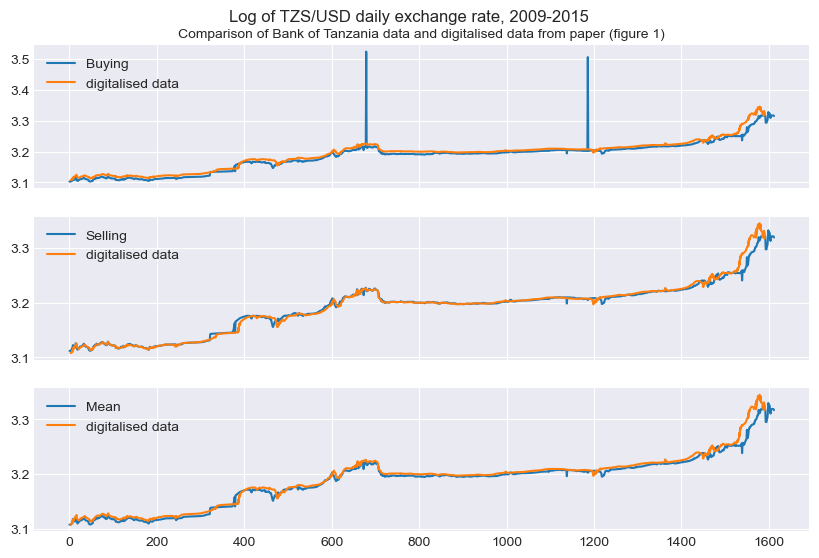

Paper appears to be using Selling as the USD/TZS Exchange Rate

In [17]:
# Comparing BoT data against digitalised data from figure 1 in report

fig,axs = plt.subplots(3,1, sharex=True)
for k, c in enumerate(['Buying', 'Selling', 'Mean']):
    axs[k].plot(np.log10(df.query("Currency=='USD'")[c].values), label=c)
    axs[k].plot(dfp.x, dfp.y, label='digitalised data')
    axs[k].legend(loc ="upper left")
plt.suptitle('Log of TZS/USD daily exchange rate, 2009-2015')
axs[0].set_title('Comparison of Bank of Tanzania data and digitalised data from paper (figure 1)', fontsize=10)
plt.subplots_adjust(top=0.92) #Adjusting title position
plt.show()
display(Markdown("Paper appears to be using Selling as the USD/TZS Exchange Rate"))

In [18]:
# Isolate USD Currency and Selling column

df.to_csv("bank_of_tanzania_all.csv", index=False)
df.query("Currency=='USD'").to_csv("bank_of_tanzania_USD.csv", index=False)

filename = 'bank_of_tanzania_USD.csv'
df = pd.read_csv(f'{base_url}/{filename}')

# df = pd.read_csv("bank_of_tanzania_USD.csv")
df = df[['Date', 'Selling']]
df.columns.values[1] = 'TZS_USD'
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d') 
df.set_index('Date', inplace=True)
df.head()

,TZS_USD
Date,
2009-01-05,1293.103
2009-01-06,1293.103
2009-01-07,1293.103
2009-01-08,1293.103
2009-01-09,1297.850


In [19]:
# Check number of missing values
df['TZS_USD'].isna().sum()

0

#### Comparison between datasets

,TZS_USD_1,TZS_USD_2,diff
Date,,,
2009-01-05,1293.103,1325.0,-31.897
2009-01-06,1293.103,1340.0,-46.897
2009-01-07,1293.103,1339.0,-45.897
2009-01-08,1293.103,1343.0,-49.897
2009-01-09,1297.850,1357.0,-59.150
...,...,...,...
2015-07-21,2095.470,2135.0,-39.530
2015-07-22,2095.470,2115.0,-19.530
2015-07-23,2095.680,2075.0,20.680


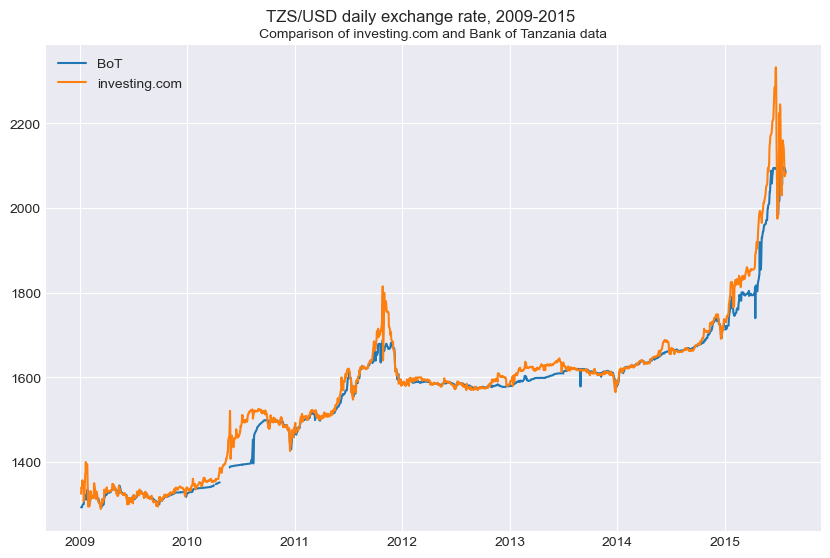

As we can see, Bank of Tanzania data appears to be less volatile than investing.com data.

In [20]:
df_comparison = pd.concat([df, df_1], axis=1)
# df_comparison = df_comparison[['TZS_USD', 'Price']]

df_comparison.columns.values[0] = 'TZS_USD_1' # Let TZS_USD_1 denote TZS/USD Exchange Rate from Bank of Tanzania
df_comparison.columns.values[1] = 'TZS_USD_2' # Let TZS_USD_2 denote TZS/USD Exchange Rate from investing.com
df_comparison['diff'] = df_comparison['TZS_USD_1'] - df_comparison['TZS_USD_2']
display(df_comparison)

# Plot 
plt.plot(df_comparison['TZS_USD_1'], label="BoT")
plt.plot(df_comparison['TZS_USD_2'], label="investing.com")
plt.legend()
plt.title('Comparison of investing.com and Bank of Tanzania data', fontsize=10)
plt.suptitle('TZS/USD daily exchange rate, 2009-2015')
plt.subplots_adjust(top=0.92) #Adjusting title position
plt.show()

display(Markdown("As we can see, Bank of Tanzania data appears to be less volatile than investing.com data."))

__Data Selection__

 - We are using the data downloaded from the Bank of Tanzania as it is the best fit to the data in the paper 

__Log TZS/USD exchange rate Transformation__
$$P_{t} = \log_{10}({E_{t}})$$

$$r_{t} = \log_{10}(\frac{E_{t}}{E_{t-1}})=\log_{10}(E_{t})-\log_{10}(E_{t-1})$$

where

$P_{t}$ is the log TZS/USD exchange rate at time t

$r_{t}$ is the log TZS/USD exchange rate relative at time t

$E_{t}$ is the TZS/USD exchange rate at time t

__Daily TZS/USD exchange rate Percentage Change Transformation__

$$r_{t} = 100 \times \left(\frac{E_{t}-E_{t-1}}{E_{t-1}}\right)$$

where

$E_{t}$ is the TZS/USD exchange rate at time t

In [21]:
# Apply transformations 
df['log_TZS_USD'] = np.log10(df['TZS_USD']) # Log Exchange Rate
df['TZS_USD_pct_change'] = 100*df['TZS_USD'].pct_change() # Percentage Change Exchnage Rate
df['log_TZS_USD_relative'] = df['log_TZS_USD'].diff() # Log Exchange Rate relative

# Drop the missing values created by functions
df.dropna(inplace=True) 

display(df)

,TZS_USD,log_TZS_USD,TZS_USD_pct_change,log_TZS_USD_relative
Date,,,,
2009-01-06,1293.103,3.111633,0.000000,0.000000
2009-01-07,1293.103,3.111633,0.000000,0.000000
2009-01-08,1293.103,3.111633,0.000000,0.000000
2009-01-09,1297.850,3.113225,0.367101,0.001591
2009-01-13,1300.375,3.114069,0.194553,0.000844
...,...,...,...,...
2015-07-21,2095.470,3.321281,-0.002863,-0.000012
2015-07-22,2095.470,3.321281,0.000000,0.000000
2015-07-23,2095.680,3.321325,0.010022,0.000044


##  Stylized Facts (Exploratory Data Analysis)

### Clustering Volatility and Leverage Effects

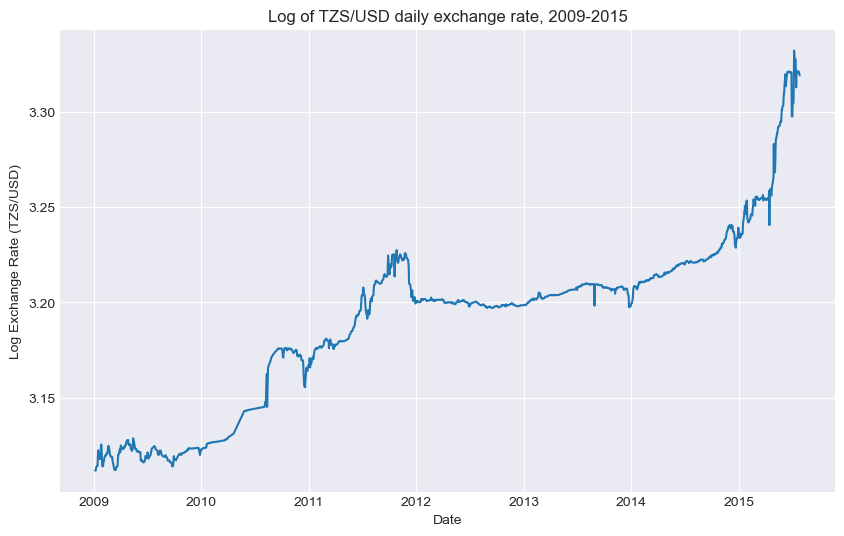

In [22]:
# Plot Log Exchange Rate (TZS/USD)
plot_series(df['log_TZS_USD'], 'Log of TZS/USD daily exchange rate, 2009-2015', 'Log Exchange Rate (TZS/USD)')

__Figure 1 comparison__

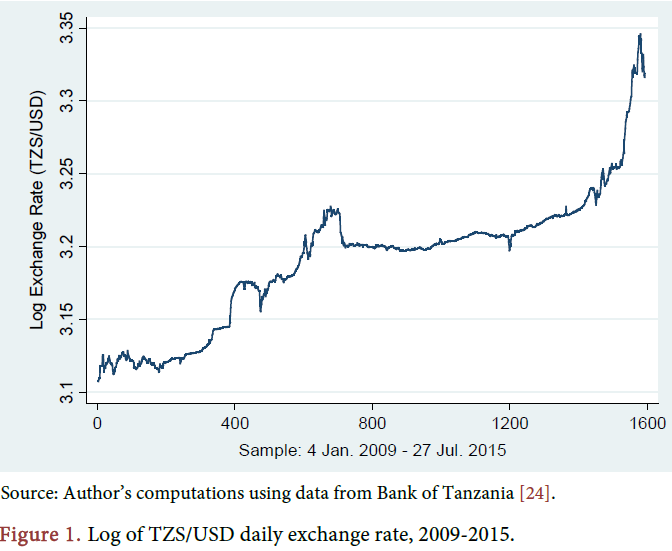

The generated plot is similar but not identical to figure 1 in the paper. Leaving the issue of different number of observations (1612 vs 1593) aside the data used in figure 1 appears to:

 * exclude a number of (outlier) observations, for example 
 2009-01-21 to 2009-01-25 ($\approx$ day 10 in paper),
 2010-05-25 to 2010-05-27 ($\approx$ day 400 in paper), etc.
 * be less noisy. Applying moving averages does not remove the inconsistencies.

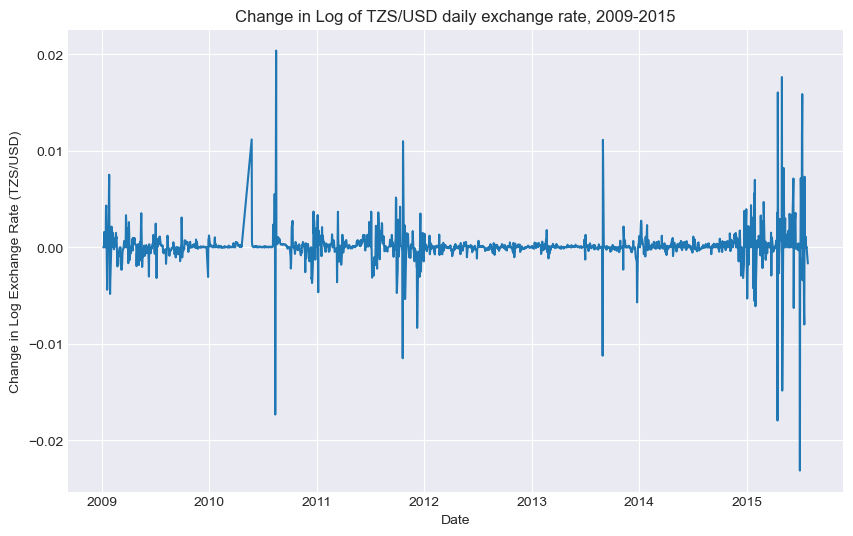

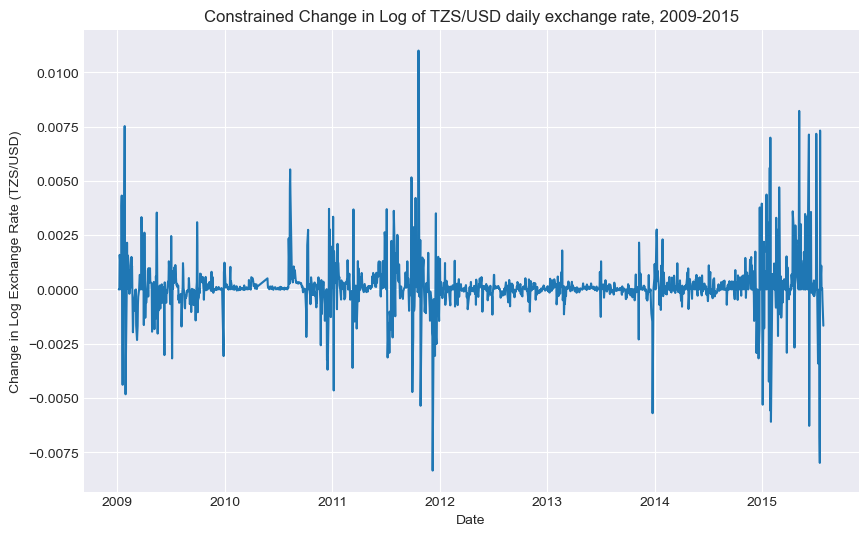

In [23]:
# Plot Change in Log Exchange Rate (TZS/USD)
plot_series(df['log_TZS_USD_relative'], 'Change in Log of TZS/USD daily exchange rate, 2009-2015', 
            'Change in Log Exchange Rate (TZS/USD)')
plot_series(df.log_TZS_USD_relative[df.log_TZS_USD_relative.abs()<0.011],
            'Constrained Change in Log of TZS/USD daily exchange rate, 2009-2015', 
            'Change in Log Exchange Rate (TZS/USD)')

__Figure 2 comparison__  

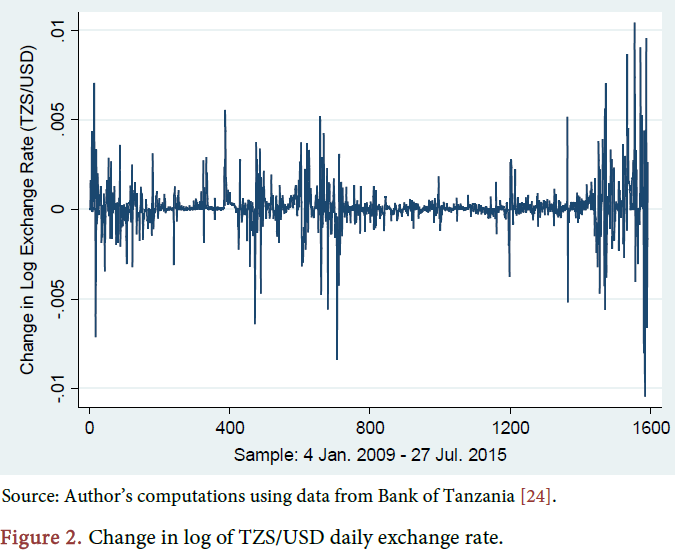

Scale in paper is smaller because that data appears to have excluded a number of observations containing spikes. 

Rerunning plot with large changes removed, we get a plot which appears to have some of the structure seen in Figure 2 but is more noisy. (This is consistent with observed discrepancies seen when generating Figure 1) 

Furthermore, it is also important to note the spike in mid 2010 in our plot. This may have been a consequence of the web scraping process. 

### Non-Normality Distribution of Fat Tails

In [24]:
# Jarque-Bera (JB) test

jb_test_data = sms.jarque_bera(df['log_TZS_USD'])
jb_test_df = pd.DataFrame(jb_test_data)
jb_test_df.columns = ['Jarque-Bera']
jb_test_df = jb_test_df.T
jb_test_df.columns = ['Test-Statistic', 'Chi^2 two-tail prob.', 'Skewness', 'Kurtosis']
display(jb_test_df)

,Test-Statistic,Chi^2 two-tail prob.,Skewness,Kurtosis
Jarque-Bera,12.147969,0.002302,0.133224,3.331465


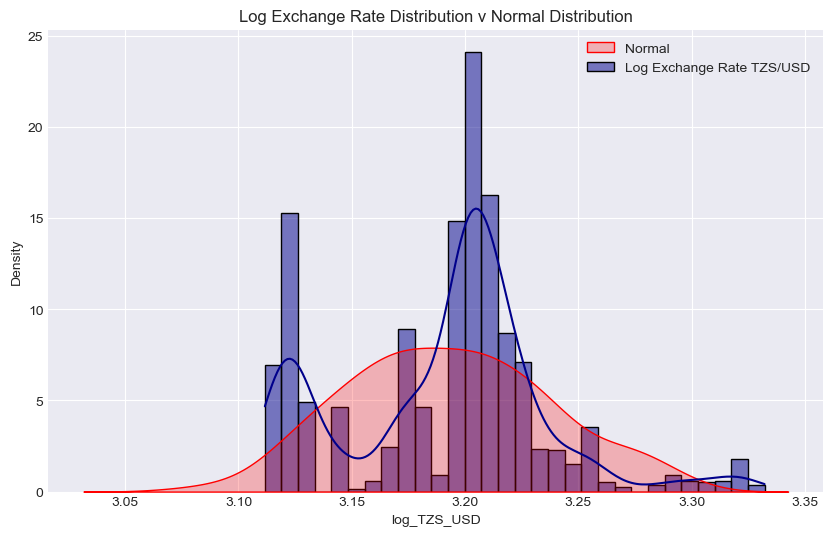

In [25]:
# Log Exchange Rate Distribution v Gaussian Distribution plot 
plot_series_v_normal(df['log_TZS_USD'], 'Log Exchange Rate TZS/USD', 
                     'Log Exchange Rate Distribution v Normal Distribution')

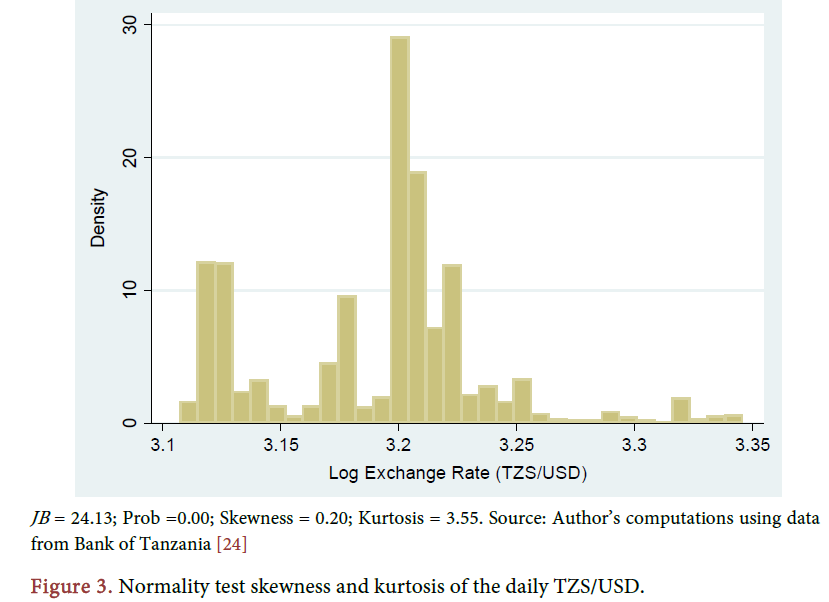

__QQ-Plot: An assessment for data normality__
A QQ-Plot is used to visually determine how close a sample is to a specified distribution
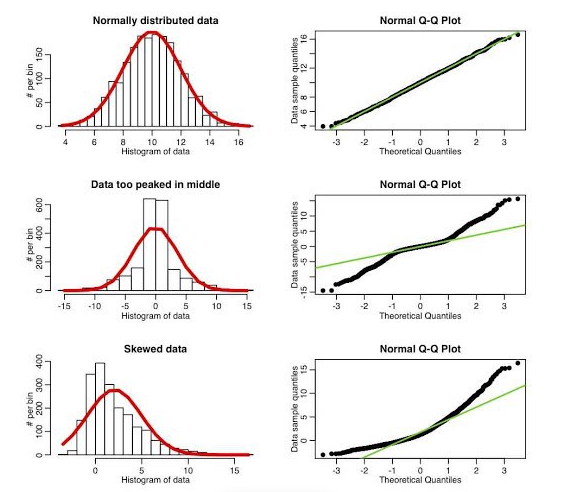

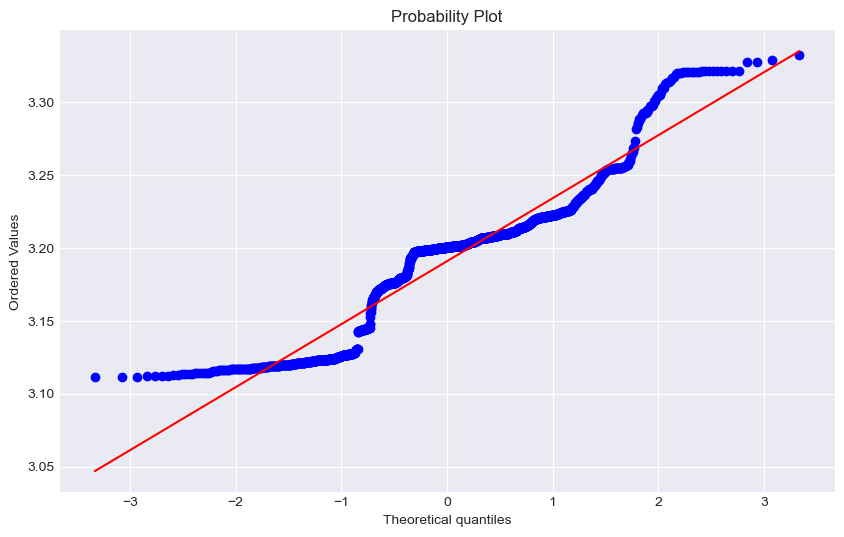

In [26]:
#QQ plot - addition -  nice to have

fig, (ax) = plt.subplots()
res = stats.probplot(df['log_TZS_USD'],dist='norm', plot=ax)

### Serial Correlation and Unit Root

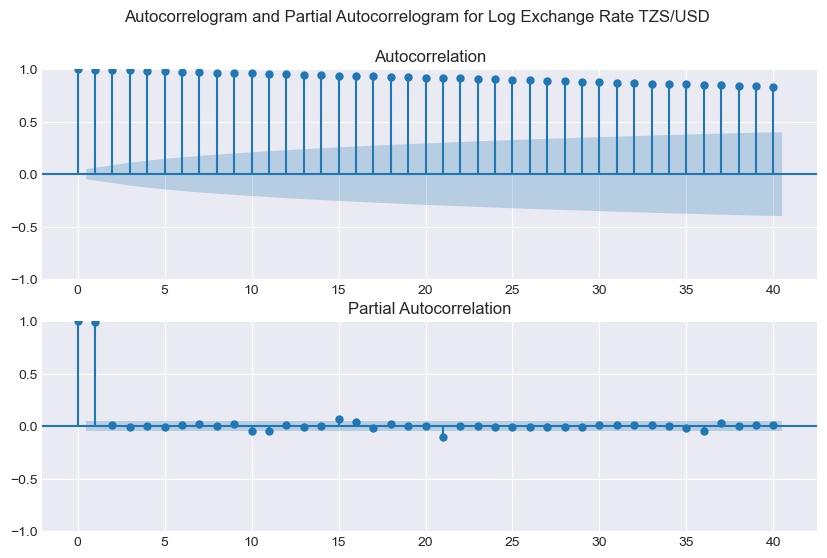

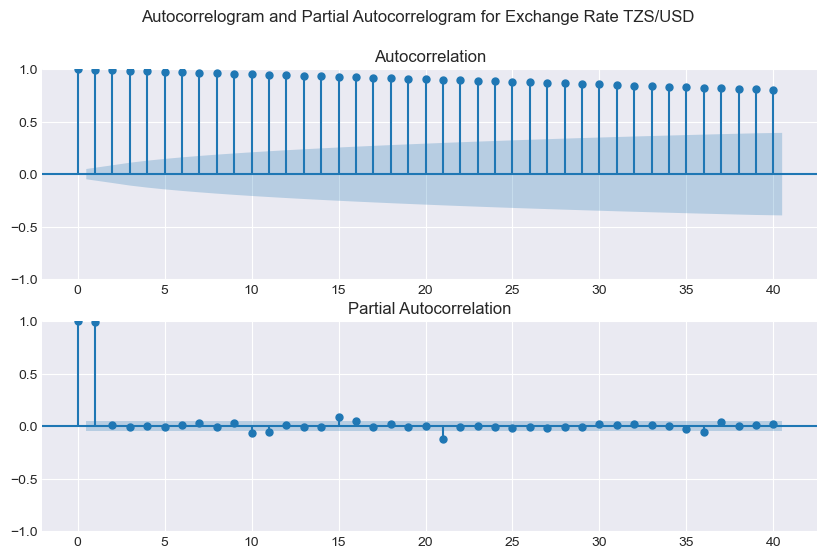

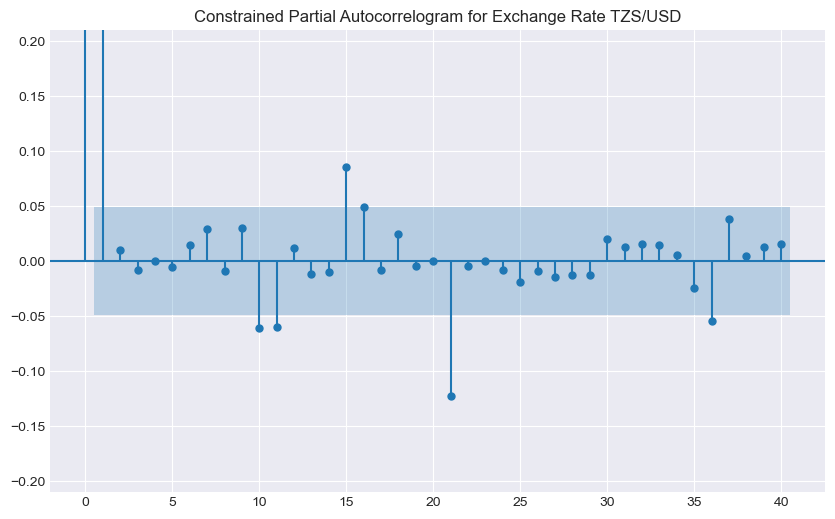

In [27]:
# Autocorrelogram and partial autocorrelogram (with 40 lags) plot
plot_acf_pacf(df['log_TZS_USD'], 'Autocorrelogram and Partial Autocorrelogram for Log Exchange Rate TZS/USD')
plot_acf_pacf(df['TZS_USD'], 'Autocorrelogram and Partial Autocorrelogram for Exchange Rate TZS/USD')

# Constraining PACF to match figure 5
plot_pacf(df['TZS_USD'], lags=40, method='ywm')
plt.ylim(-0.21, 0.21)
plt.title('Constrained Partial Autocorrelogram for Exchange Rate TZS/USD')
plt.show()

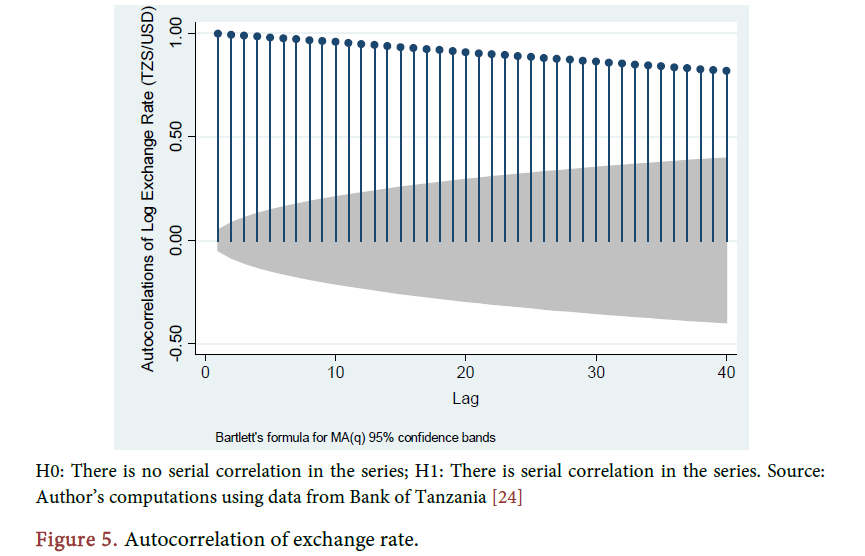
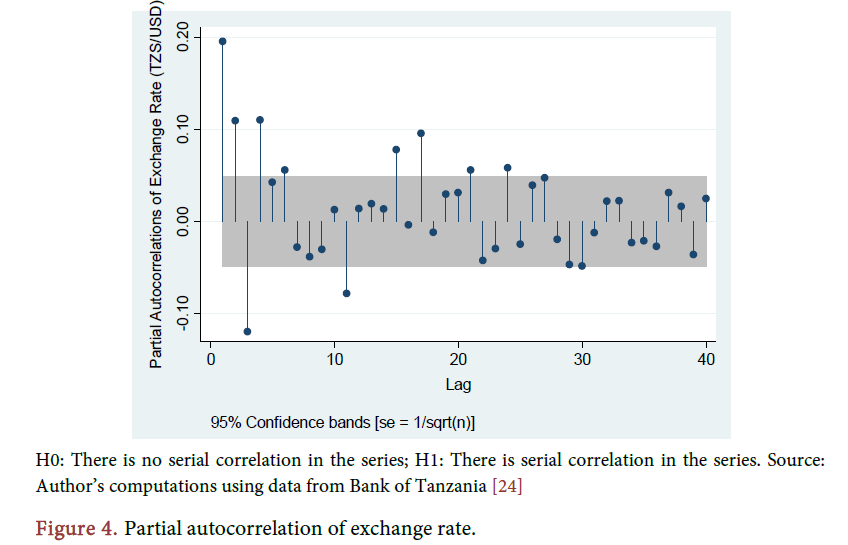

__Figure 4 and 5 comparison__

Author seems to be plotting Autocorrelogram and Partial Autocorrelogram for both Exchange Rate TZS/USD and Log Exchange Rate TZS/USD.

Our Autocorrelogram matches figure 5 as per the paper. The PACF does not appear to match figure 4, even after constraining it to the limits to match figure 4. This will need to be investigated.

_Note_: Author is using STATA which does include lag=0 in its plot 

In [28]:
# ADF and PP unit root tests for stationarity code

adf_level = ADF(df['log_TZS_USD'], lags=40)
print(adf_level.summary())

pp_level = PP(df['log_TZS_USD'], lags=40)
print(pp_level.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                  0.884
P-value                         0.993
Lags                               40
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                  0.870
P-value                         0.993
Lags                               40
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [29]:
# ADF and PP unit root tests for stationarity in first difference code

adf_diff = ADF(df['log_TZS_USD_relative'], lags=40)
print(adf_diff.summary())

pp_diff = PP(df['log_TZS_USD_relative'], lags=40)
print(pp_diff.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -6.124
P-value                         0.000
Lags                               40
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -45.285
P-value                         0.000
Lags                               40
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Parametric Volatility Models & Empirical Results
In this paper both GARCH (1,1) and EGARCH (1,1) are used to model the volatility of TZS/USD exchange rate for the January 4, 2009 - July 27, 2015 period.

Before estimating the ARCH and GARCH models, the paper investigates the exchange rate series in order to identify its statistical properties and to see if it meets the pre-conditions for the ARCH and GARCH models, that is, clustering volatility and ARCH effect in the residuals.

### The ARCH Effect
Test for the presence of ARCH effect is performed by first applying the least squares (LS) method in order to generate regression residuals. Then the ARCH heteroskedasticity test is applied to the residuals to ascertain whether time varying volatility clustering does exist.

In [30]:
# ARCH effect test using Least Square method

ex_rate_pct_change = df['TZS_USD_pct_change']

# Fit a model (From Tutorial 9)
arch_effect_ols = smf.ols(formula='ex_rate_pct_change ~ 1',data=df).fit() 
print(arch_effect_ols.summary())
dw_test = sms.durbin_watson(arch_effect_ols.resid)
print('\n','Durbin-Watson Statistic: ', dw_test)

                            OLS Regression Results                            
Dep. Variable:     ex_rate_pct_change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 02 Dec 2022   Prob (F-statistic):                nan
Time:                        18:15:50   Log-Likelihood:                -917.77
No. Observations:                1612   AIC:                             1838.
Df Residuals:                    1611   BIC:                             1843.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0306      0.011      2.869      0.0

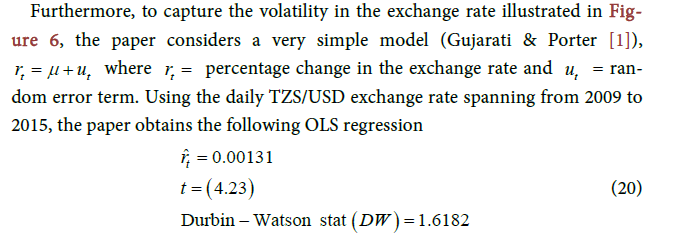

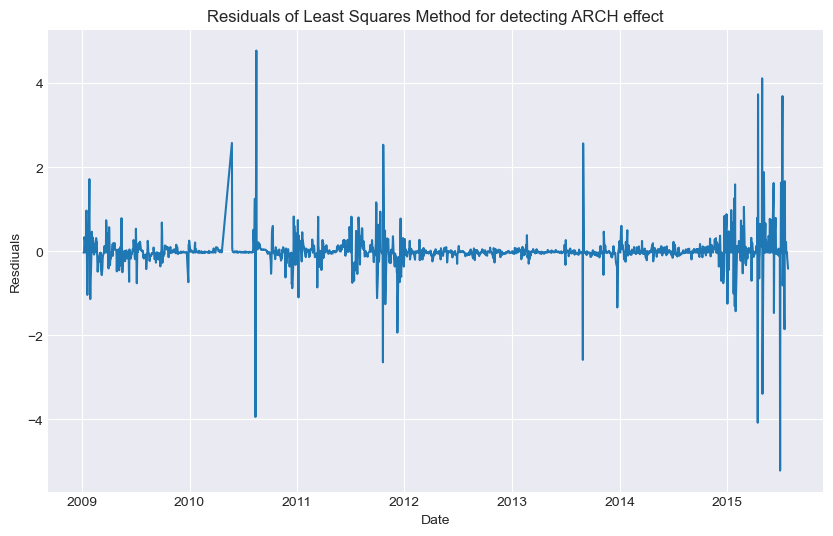

In [31]:
plot_series(arch_effect_ols.resid, 'Residuals of Least Squares Method for detecting ARCH effect', ylabel='Resdiuals')

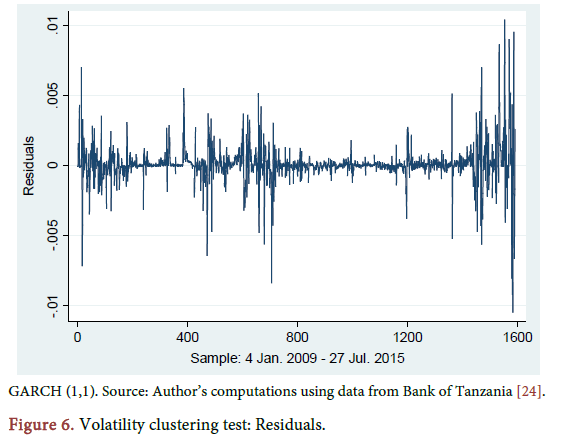

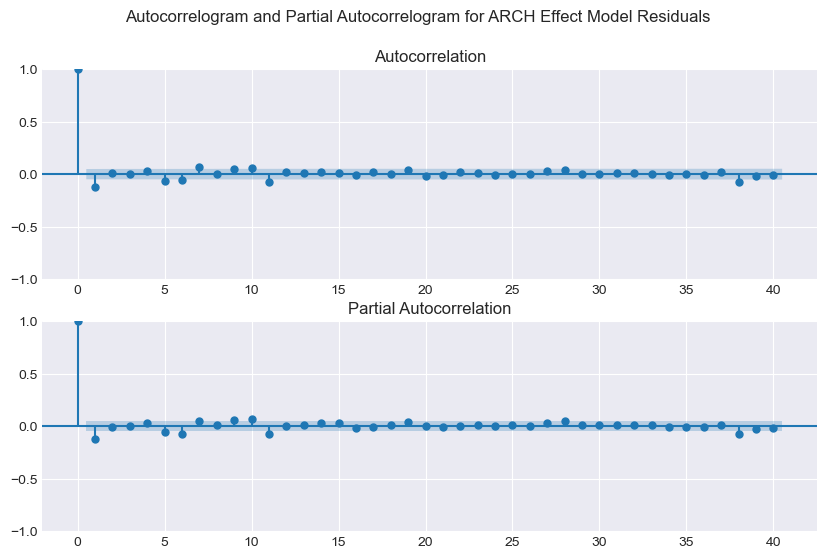

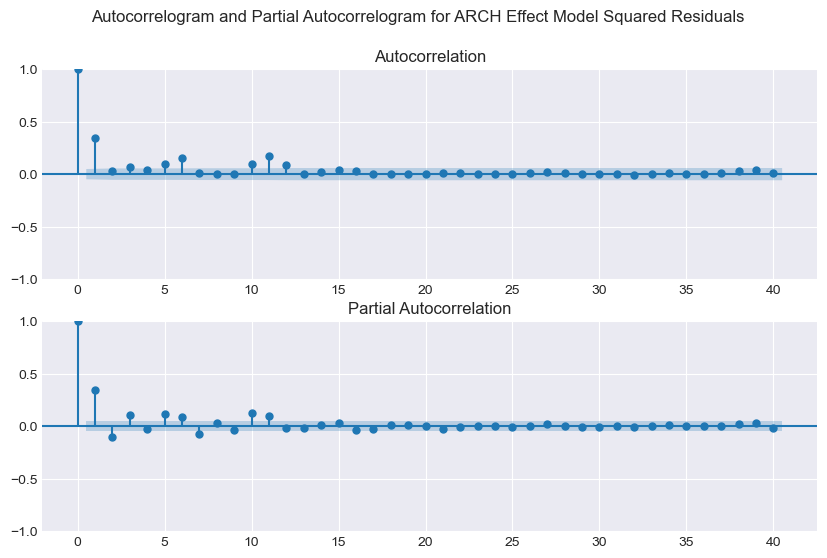

In [32]:
# Optional (from tutoriaL)
# Residuals correlation: No serial correlation for residuals from the model（assumption)
# Positive correlations found for squared residuals: one way to detect ARCH effect

plot_acf_pacf(arch_effect_ols.resid, 'Autocorrelogram and Partial Autocorrelogram for ARCH Effect Model Residuals')
plot_acf_pacf(np.square(arch_effect_ols.resid), 'Autocorrelogram and Partial Autocorrelogram for ARCH Effect Model Squared Residuals')

__Testing for ARCH Effect: Engle’s Test for Autoregressive Conditional Heteroscedasticity__

$H_{0}$: There is no conditional heteroscedasticity/ No ARCH effect is present

$H_{1}$: There is conditional heteroscedasticity/ ARCH effect is present

In [33]:
# ARCH LM test (Engle's Test) for autoregressive conditional heteroskedasticity (ARCH)

engle_test_data = sm.stats.diagnostic.het_arch(arch_effect_ols.resid)
engle_test_df = pd.DataFrame(engle_test_data)
engle_test_df.columns = ['Engle Test']
engle_test_df = engle_test_df.T
engle_test_df.columns = ['Lagrange Multiplier Test Statistic', 'LM p-value', 'F-statistic', 'F p-value']
display(engle_test_df)

,Lagrange Multiplier Test Statistic,LM p-value,F-statistic,F p-value
Engle Test,284.122914,3.511567e-55,34.300585,6.092688e-61


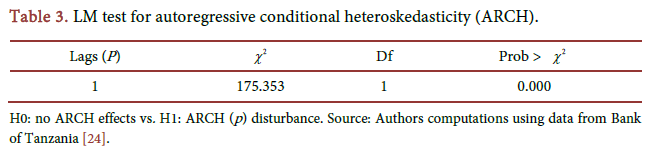

In [34]:
# From tutorial - ARCH(1)
arch_effect = arch_model(df['TZS_USD_pct_change'], vol='ARCH', p=1, q=0, rescale=False).fit()
print(arch_effect.summary())
dw_test = sms.durbin_watson(arch_effect.resid)
print('\n','Durbin-Watson Statistic: ', dw_test)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18634.843418051947
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2073.7121098661282
Iteration:      3,   Func. Count:     21,   Neg. LLF: 495.93846597236677
Iteration:      4,   Func. Count:     26,   Neg. LLF: 490.7282989072106
Iteration:      5,   Func. Count:     31,   Neg. LLF: 490.5375165153817
Iteration:      6,   Func. Count:     35,   Neg. LLF: 490.53614887474953
Iteration:      7,   Func. Count:     39,   Neg. LLF: 490.53614574637714
Iteration:      8,   Func. Count:     42,   Neg. LLF: 490.53614574637095
Optimization terminated successfully    (Exit mode 0)
            Current function value: 490.53614574637714
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8
                      Constant Mean - ARCH Model Results                      
Dep. Variable:     TZS_USD_pct_change   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squar

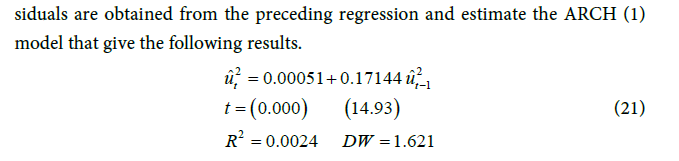

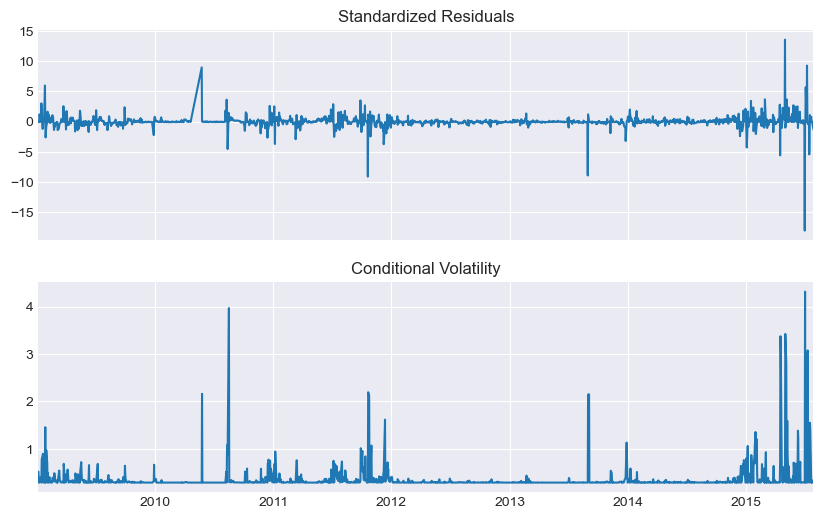

In [35]:
# From tutorial
std_resid_con_vol_plot = arch_effect.plot()

### The GARCH Model

#### Results

In [36]:
# GARCH(1,1)
garch_model_11 = arch_model(df['TZS_USD_pct_change'], vol='GARCH', p=1, q=1, rescale=False).fit()
print(garch_model_11.summary())
dw_test = sms.durbin_watson(garch_model_11.resid)
print('\n','Durbin-Watson Statistic: ', dw_test)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1096588.622812618
Iteration:      2,   Func. Count:     18,   Neg. LLF: 33765.74062626453
Iteration:      3,   Func. Count:     25,   Neg. LLF: 676.1954087330912
Iteration:      4,   Func. Count:     33,   Neg. LLF: 2567.4046552259497
Iteration:      5,   Func. Count:     40,   Neg. LLF: 176.10488303449847
Iteration:      6,   Func. Count:     45,   Neg. LLF: 174.1489575719456
Iteration:      7,   Func. Count:     50,   Neg. LLF: 173.30466491282678
Iteration:      8,   Func. Count:     55,   Neg. LLF: 173.30453492401776
Iteration:      9,   Func. Count:     60,   Neg. LLF: 173.30453311231534
Iteration:     10,   Func. Count:     65,   Neg. LLF: 173.30453476219193
Optimization terminated successfully    (Exit mode 0)
            Current function value: 173.30453311466707
            Iterations: 10
            Function evaluations: 75
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results        

In [37]:
# Checking sum of coefficients
alpha = garch_model_11.params[2] # coefficient of lagged squared residual
beta = garch_model_11.params[3] # coefficient of lagged conditional variance
sum_coefficients_garch_model_11 = alpha + beta
sum_coefficients_garch_model_11

1.0000000097808792

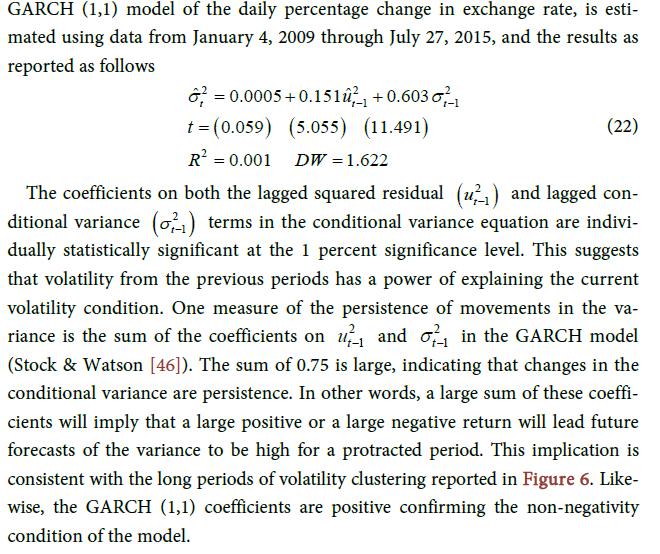

#### Diagnostic Checking of the GARCH (1,1) Model
Goodness of fit of the ARCH-GARCH model is based on residuals. The residuals are assumed to be independently and identically distributed following a normal or standardized t-distribution. If the model fits the data well the histogram of the residuals should be approximately symmetric. The ACF and the PACF of the standardized residuals are used for checking the adequacy of the conditional variance model.

##### Normality Test of the Residuals

In [38]:
# Shapiro-Wilk test
sw_test = sw(garch_model_11.resid)
sw_test

ShapiroResult(statistic=0.497205913066864, pvalue=0.0)

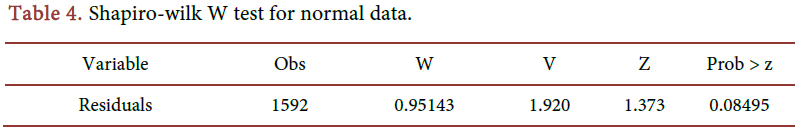

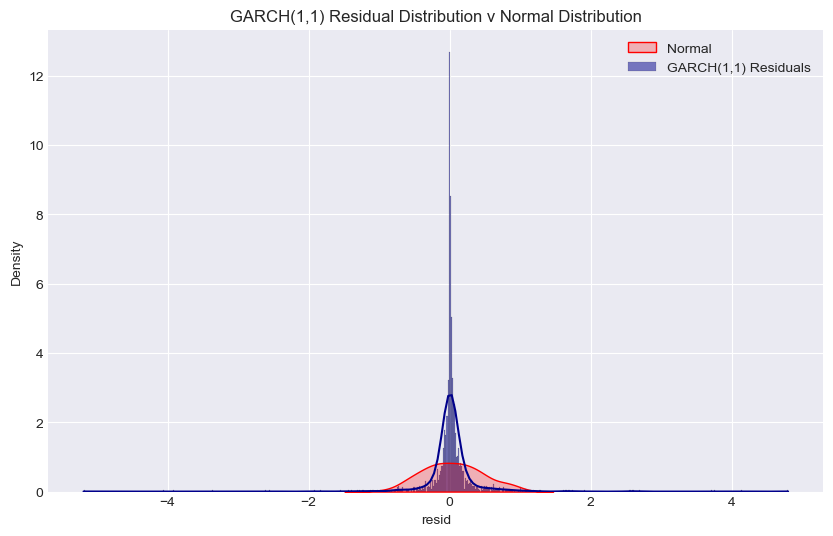

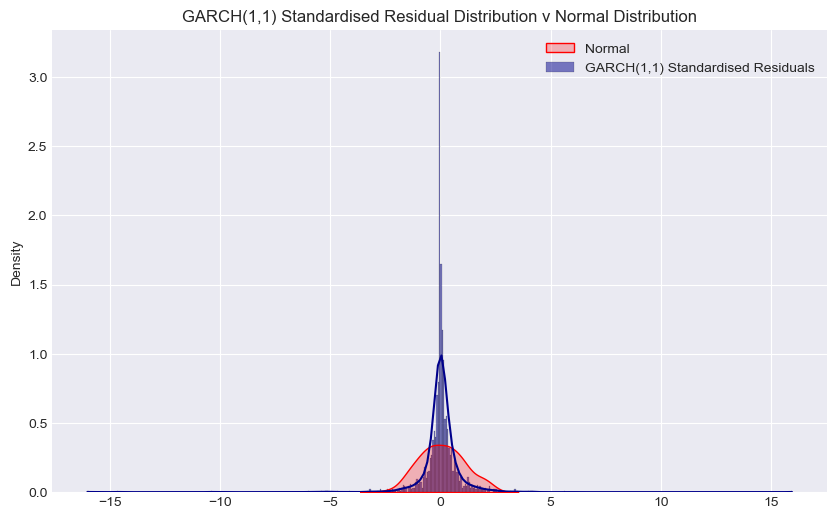

In [39]:
# GARCH (1,1) Residual Distribution v Normal Distribution plot 
plot_series_v_normal(garch_model_11.resid, 'GARCH(1,1) Residuals', 
                     'GARCH(1,1) Residual Distribution v Normal Distribution')

# Tutorial does standardised residuals
garch_model_11_st_resid = np.divide(garch_model_11.resid, garch_model_11.conditional_volatility)

# GARCH (1,1) Standardised Residual Distribution v Normal Distribution plot 
plot_series_v_normal(garch_model_11_st_resid, 'GARCH(1,1) Standardised Residuals', 
                     'GARCH(1,1) Standardised Residual Distribution v Normal Distribution')

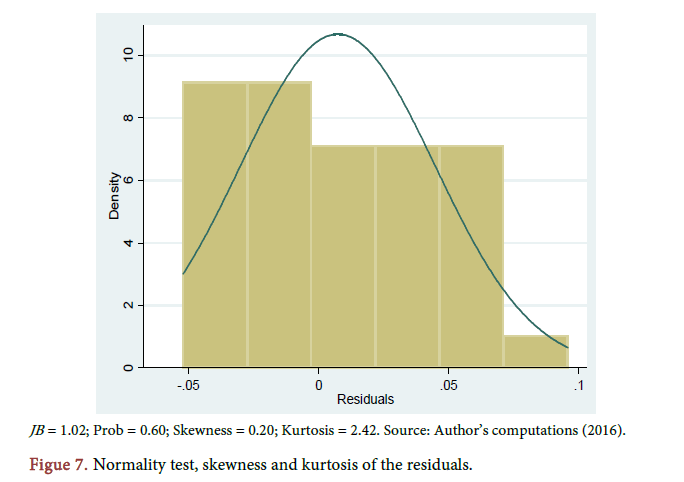

"If the model fits the data well the histogram of the residuals should be approximately symmetric."

In [40]:
# Jarque-Bera (JB) test

jb_test_data = sms.jarque_bera(garch_model_11.resid)
jb_test_df = pd.DataFrame(jb_test_data)
jb_test_df.columns = ['Jarque-Bera']
jb_test_df = jb_test_df.T
jb_test_df.columns = ['Test-Statistic', 'Chi^2 two-tail prob.', 'Skewness', 'Kurtosis']
display(jb_test_df)

,Test-Statistic,Chi^2 two-tail prob.,Skewness,Kurtosis
Jarque-Bera,185284.81876,0.0,0.112329,55.521733


##### Serial Correlation

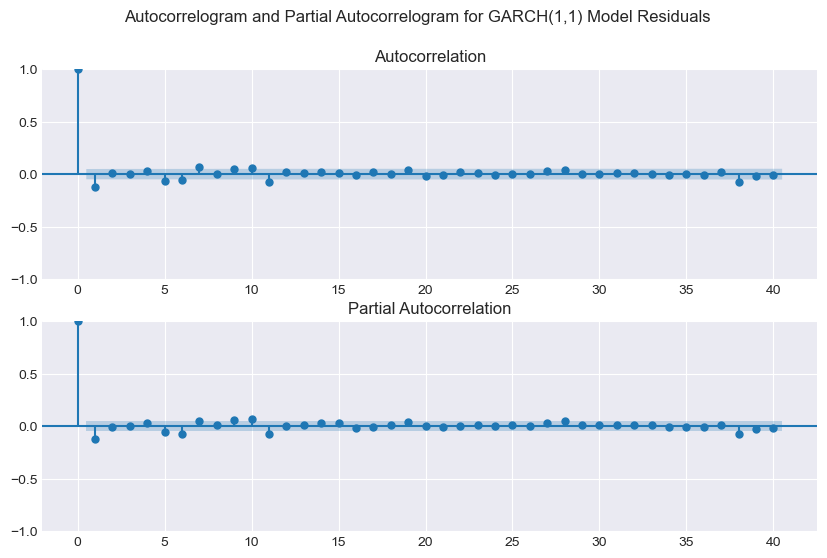

In [41]:
# Partial autocorrelogram and autocorrelogram (with 40 lags) of Residuals plot
plot_acf_pacf(garch_model_11.resid, 'Autocorrelogram and Partial Autocorrelogram for GARCH(1,1) Model Residuals')

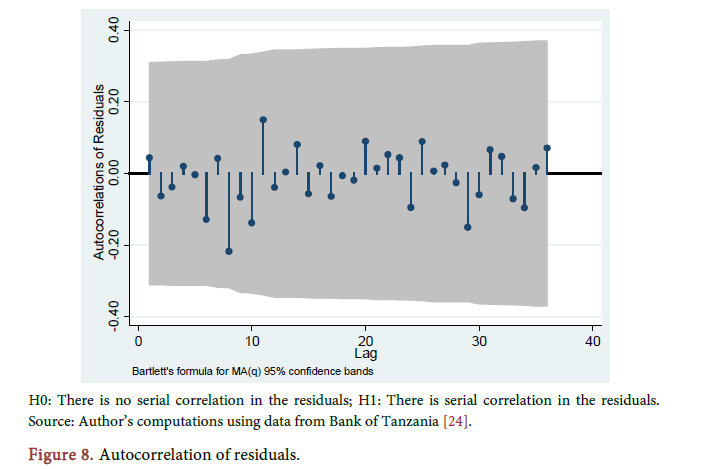
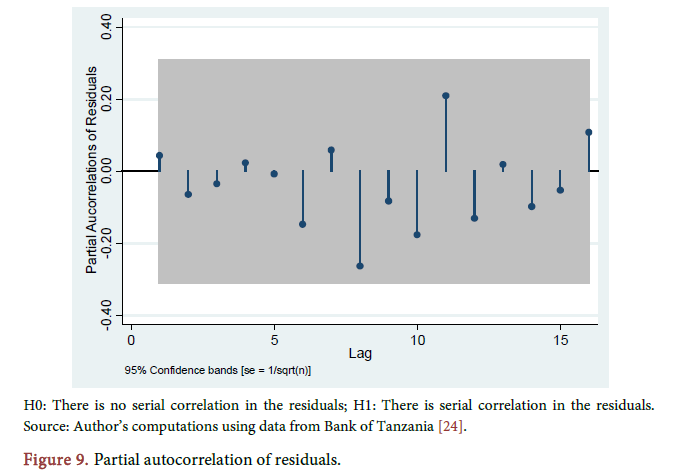

In [42]:
# Serial correlation test - Ljung-Box test
LB_test_data = acorr_ljungbox(garch_model_11.resid, lags=40)
LB_test_df = pd.DataFrame.from_records(LB_test_data)
LB_test_df = LB_test_df.rename_axis('Lags') # Rename index
LB_test_df.index = LB_test_df.index + 1 # Set first row to 1 instead of 0
LB_test_df.rename(columns={'lb_stat': 'Q stat','lb_pvalue':'P-Value'},inplace=True) # Rename columns
LB_test_df

,Q stat,P-Value
Lags,,
1,25.756952,3.872296e-07
2,25.964326,2.301009e-06
3,25.967641,9.687357e-06
4,27.114858,1.884378e-05
5,33.882441,2.512813e-06
6,39.464251,5.803817e-07
7,46.309947,7.608082e-08
8,46.310302,2.074972e-07
9,50.534045,8.547062e-08


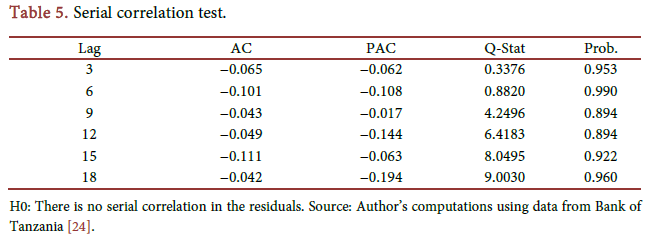

### The Leverage Effects and Asymmetric GARCH

In [43]:
# Exponential GARCH (EGARCH) EGARCH (1,1)
egarch_model_11 = arch_model(df['TZS_USD_pct_change'], vol='EGARCH', p=1, q=1, o=1, rescale=False).fit()
print(egarch_model_11.summary())
dw_test = sms.durbin_watson(egarch_model_11.resid)
print('\n','Durbin-Watson Statistic: ', dw_test)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 77012796253595.12
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4107987971543.1484
Iteration:      3,   Func. Count:     30,   Neg. LLF: 3094.8053695710128
Iteration:      4,   Func. Count:     40,   Neg. LLF: 446168286696.89905
Iteration:      5,   Func. Count:     49,   Neg. LLF: 1128.6070886910009
Iteration:      6,   Func. Count:     56,   Neg. LLF: 120239383296.81186
Iteration:      7,   Func. Count:     65,   Neg. LLF: 777.4225195334895
Iteration:      8,   Func. Count:     72,   Neg. LLF: 396.6452977622971
Iteration:      9,   Func. Count:     79,   Neg. LLF: 235.1725611672358
Iteration:     10,   Func. Count:     85,   Neg. LLF: 234.94179743224117
Iteration:     11,   Func. Count:     91,   Neg. LLF: 234.92058835721673
Iteration:     12,   Func. Count:     97,   Neg. LLF: 234.92003863943188
Iteration:     13,   Func. Count:    103,   Neg. LLF: 234.92001516038692
Iteration:     14,   Func. Count:    108,   Neg. LLF: 2

__EGARCH Coefficents__

AS PER PAPER
 - Our Omega is constant 
 - Our Alpha is coefficent on first term
 - Our Beta is coefficient on second term
 - Our Gamma is coefficient on third term

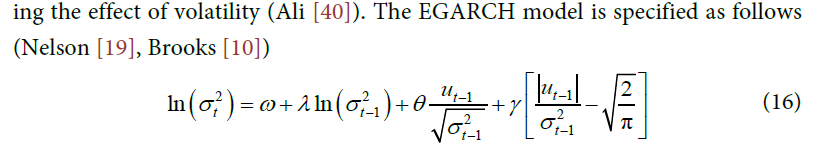
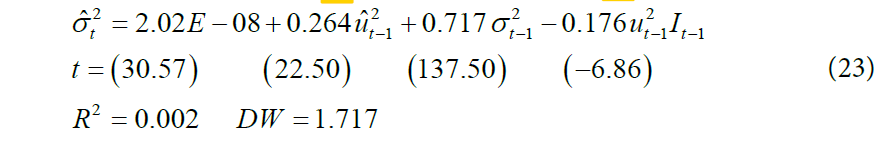

### Forecasting Evaluation and Accuracy
To measure the forecasting ability, the paper estimates within sample forecasts. The purpose of forecasting within the sample is to test for the predictability power of the model. If the magnitude of the difference between the actual and forecasted values is small then the model has good forecasting power.

(i.e. they do not split data into training and testing)

__Realised Variance__

From "Franses, P.H. and Dijk, D.V. (1996) Forecasting Stock Market Volatility Using (Non-Linear) GARCH Models. Journal of Forecasting , 15, 229-235."

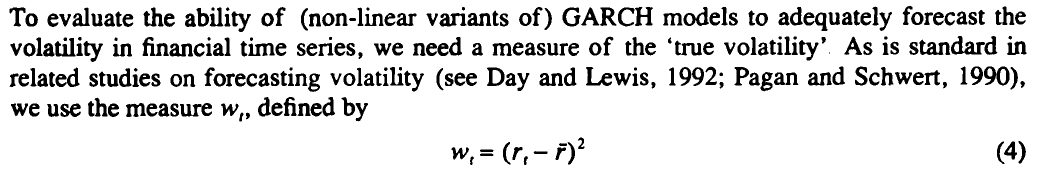

In [44]:
# Isolate actuals and predict using model

start = dt.datetime(2009,1,5)

predictions = garch_model_11.forecast(horizon=1, start=1, reindex=False)
var_predictions = predictions.variance
var_predictions.columns.values[0] = 'Forecasted Variance'

df_forecast_actuals = pd.concat([df, var_predictions], axis=1)
df_forecast_actuals['Realised Variance'] = np.square(df['TZS_USD_pct_change'] - df['TZS_USD_pct_change'].mean())
df_forecast_actuals.dropna(inplace=True) 
df_forecast_actuals = df_forecast_actuals[['Realised Variance','Forecasted Variance']]
df_forecast_actuals

,Realised Variance,Forecasted Variance
Date,,
2009-01-07,0.000934,0.199321
2009-01-08,0.000934,0.169887
2009-01-09,0.113260,0.167283
2009-01-13,0.026893,0.149175
2009-01-14,0.000934,0.128210
...,...,...
2015-07-21,0.001117,1.741809
2015-07-22,0.000934,1.451873
2015-07-23,0.000422,1.210895


In [45]:
actuals = df_forecast_actuals['Realised Variance']
predictions = df_forecast_actuals['Forecasted Variance']
error = actuals - predictions
error = error.dropna()
log_error = np.log10(abs(error))
log_error

Date
2009-01-07   -0.702487
2009-01-08   -0.772233
2009-01-09   -1.267421
2009-01-13   -0.912639
2009-01-14   -0.895252
                ...   
2015-07-21    0.240722
2015-07-22    0.161649
2015-07-23    0.082955
2015-07-24   -0.003667
2015-07-27   -0.154551
Length: 1611, dtype: float64

__Mean absolute error (MAE) and Root Mean Squared Error (RMSE)__
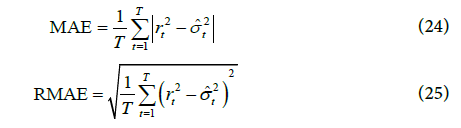

__Theil’s U-statistic__
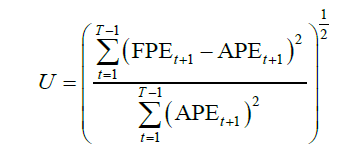
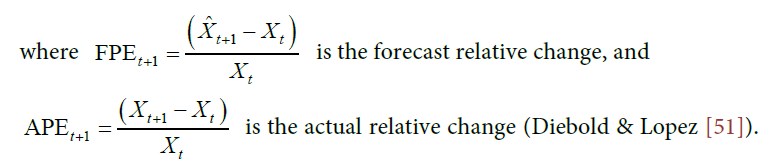

In [46]:
# Mean absolute error (MAE); the Root Mean Squared Error (RMSE); and Theil’s U-statistic
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
             
# Theil’s U-statistic - seems to have no library for this test - Calculate manually
def theil_u_statistic(actual, predicted):
    """Calculate Theil's U-statistic"""
    
    fpe = (predicted[1:] - actual[:-1]) / actual[:-1]
    
    ape = actuals.pct_change()
    
    u = np.sqrt( np.sum(np.square(fpe-ape)) / (np.sum(np.square(ape))) )
    
    print(f'Theil’s U-statistic: {u}')
         
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
theil_u_statistic(actuals, predictions)

Root Mean Squared Error: 1.110774676220311
Mean Absolute Error: 0.23987201344187326
Theil’s U-statistic: 1.4183779162957852


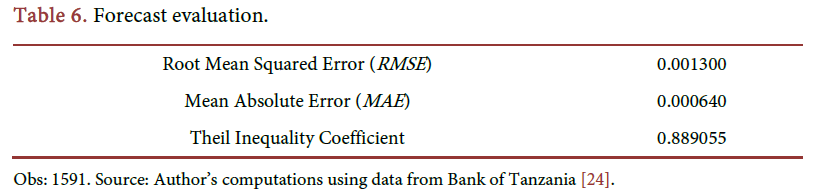

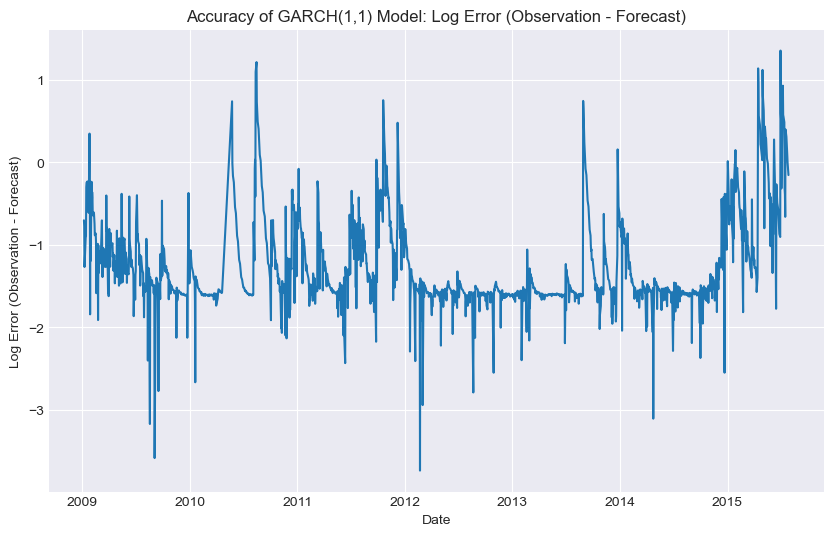

In [47]:
# Difference between actual and forecasted volatility plot
plot_series(log_error, 'Accuracy of GARCH(1,1) Model: Log Error (Observation - Forecast)', 
            'Log Error (Observation - Forecast)')

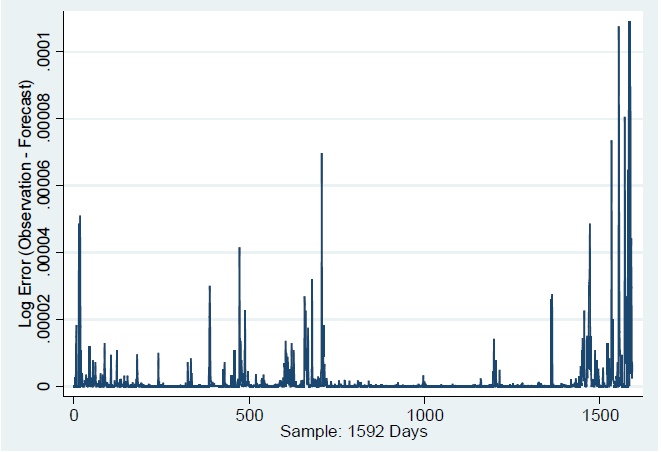